In [1]:
%load_ext autoreload
%autoreload 2
from movielens import *
from movielens_experiments import *
import pickle
from sklearn.manifold import TSNE

# Experiments with MovieLens

## 1. Load user + movie embeddings

In [2]:
np.random.seed(0)
R, user_mapping, movie_mapping = load_movielens_ratings(user_min_count=50, movie_min_count=50, dataset='1m')

Loading from ./ml-1m/ratings.dat...


/dfs/scratch0/serinac/polar_rec/movielens.py:31: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(fn, sep='::', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])


Finished loading: found 1000209 ratings
Dropped 1192 movies with < 50 ratings
Dropped 1743 users with < 50 ratings
Created ratings matrix: (4297, 2514)


In [3]:
num_ratings_per_user = np.sum(R>0, axis=1)
print('First 5 users:', num_ratings_per_user[:5])  # should be in descending order
num_ratings_per_movie = np.sum(R>0, axis=0)
print('First 5 movies:', num_ratings_per_movie[:5])
print('Num ratings per user: min=%d, median=%d, mean=%d, max=%d' % (
    np.min(num_ratings_per_user), np.median(num_ratings_per_user), np.mean(num_ratings_per_user), np.max(num_ratings_per_user)))
print('Num ratings per movie: min=%d, median=%d, mean=%d, max=%d' % (
    np.min(num_ratings_per_movie), np.median(num_ratings_per_movie), np.mean(num_ratings_per_movie), np.max(num_ratings_per_movie)))

First 5 users: [1890 1649 1546 1488 1442]
First 5 movies: [2758 2652 2585 2457 2343]
Num ratings per user: min=31, median=144, mean=214, max=1890
Num ratings per movie: min=45, median=227, mean=366, max=2758


In [5]:
movie_df = load_movie_data(reindexing=movie_mapping, dataset='1m')
movie_df.head()

Loading from ./ml-1m/movies.dat...
Finished loading: found 3883 movies
Kept 2514 movies


/dfs/scratch0/serinac/polar_rec/movielens.py:164: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(fn, sep='::', header=None, names=['movieId', 'title', 'genres'])


,title,genres
movieId,,
0,American Beauty (1999),Comedy|Drama
1,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
2,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
3,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
4,"Matrix, The (1999)",Action|Sci-Fi|Thriller


In [6]:
from collections import Counter

all_genres = []
for g in movie_df.genres.values:
    all_genres.extend(g.split('|'))
genre_counter = Counter(all_genres)
print(genre_counter)

Counter({'Drama': 938, 'Comedy': 852, 'Action': 427, 'Thriller': 393, 'Romance': 328, 'Sci-Fi': 241, 'Horror': 241, 'Adventure': 235, "Children's": 197, 'Crime': 142, 'War': 116, 'Musical': 95, 'Mystery': 89, 'Animation': 88, 'Fantasy': 62, 'Western': 50, 'Documentary': 38, 'Film-Noir': 31})


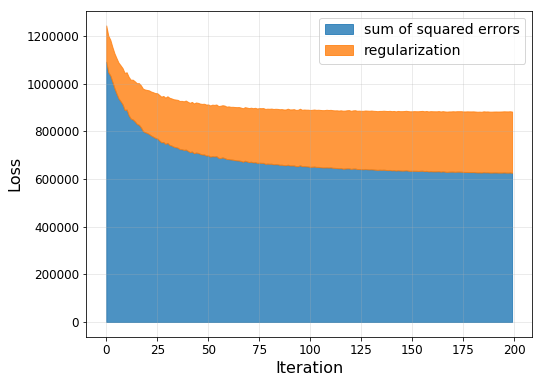

In [8]:
# Appendix Figure 1
fn = 'euclidean_embs_1m_5D.pkl'  # saved from running fit_and_save_embeddings() in movielens_experiments.py
f = open(fn, 'rb')
(mu, lmb), final, argmin, losses = pickle.load(f)
f.close()

sse = losses[1]
reg_loss = losses[2]
plt.figure(figsize=(8, 6))
plt.fill_between(range(len(sse)), np.zeros(len(sse)), sse, color='tab:blue', alpha=0.8, label='sum of squared errors')
plt.fill_between(range(len(sse)), sse, np.array(sse) + np.array(reg_loss), color='tab:orange', alpha=0.8, label='regularization')
plt.legend(fontsize=14)
plt.grid(alpha=0.3)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.tick_params(labelsize=12)
plt.show()
# could check how much parameters are changing per iteration, should see change go down

User mean [0.561 0.385 0.417 0.495 0.483]
User covariance
[[ 0.058  0.01   0.006  0.016  0.014]
 [ 0.01   0.062 -0.006  0.011  0.014]
 [ 0.006 -0.006  0.074  0.005  0.014]
 [ 0.016  0.011  0.005  0.063  0.015]
 [ 0.014  0.014  0.014  0.015  0.065]]
Movie mean [0.401 0.695 0.637 0.514 0.548]
Movie covariance
[[ 0.126  0.004 -0.011 -0.019 -0.003]
 [ 0.004  0.16   0.046  0.024  0.024]
 [-0.011  0.046  0.211  0.032  0.015]
 [-0.019  0.024  0.032  0.164  0.011]
 [-0.003  0.024  0.015  0.011  0.153]]


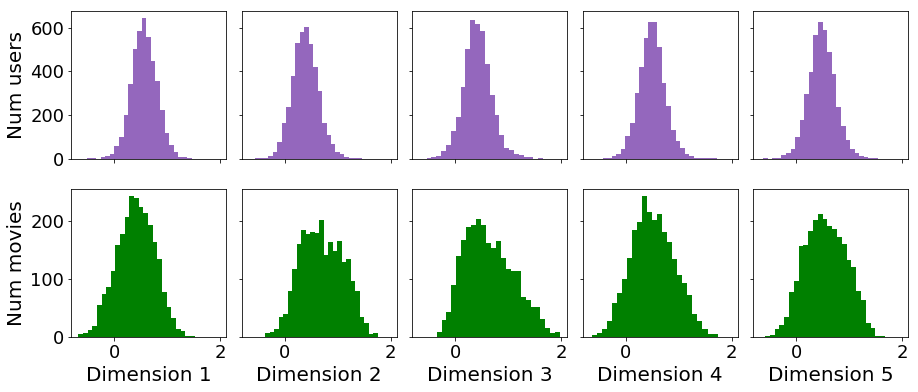

In [87]:
# Figure 5
bu, X, Y = final
n_dim = X.shape[1]
fig, axes = plt.subplots(2, n_dim, figsize=(3 * n_dim, 6), sharex=True)
fig.subplots_adjust(wspace=0.1)

X_mean = np.mean(X, axis=0)
X_cov = np.cov(X, rowvar=0)
print('User mean', np.round(X_mean, 3))
print('User covariance')
print(np.round(X_cov, 3))
max_y = 0
for i in range(n_dim):
    ax = axes[0][i]
    ax.hist(X[:, i], color='tab:purple', bins=25)
    if i == 0: 
        ax.set_ylabel('Num users', fontsize=20)
    else:
        ax.set_yticklabels([])
    y_lim = ax.get_ylim()[1]
    if y_lim > max_y:
        max_y = y_lim
    ax.tick_params(labelsize=18)
for i in range(n_dim):
    axes[0][i].set_ylim((0, max_y))        

Y_mean = np.mean(Y, axis=0)
Y_cov = np.cov(Y, rowvar=0)
print('Movie mean', np.round(Y_mean, 3))
print('Movie covariance')
print(np.round(Y_cov, 3))
max_y = 0
for i in range(n_dim):
    ax = axes[1][i]
    ax.hist(Y[:, i], color='green', bins=25)
    ax.set_xlabel('Dimension %d' % (i+1), fontsize=20)
    if i == 0: 
        ax.set_ylabel('Num movies', fontsize=20)
    else:
        ax.set_yticklabels([])
    y_lim = ax.get_ylim()[1]
    if y_lim > max_y:
        max_y = y_lim
    ax.tick_params(labelsize=18)
for i in range(n_dim):
    axes[1][i].set_ylim((0, max_y))
plt.show()

Drama: n=938
Comedy: n=852
Action: n=427
Thriller: n=393
Romance: n=328
Sci-Fi: n=241
Horror: n=241
Adventure: n=235
Children's: n=197
Crime: n=142
War: n=116
Musical: n=95
Mystery: n=89
Animation: n=88
Fantasy: n=62
Western: n=50


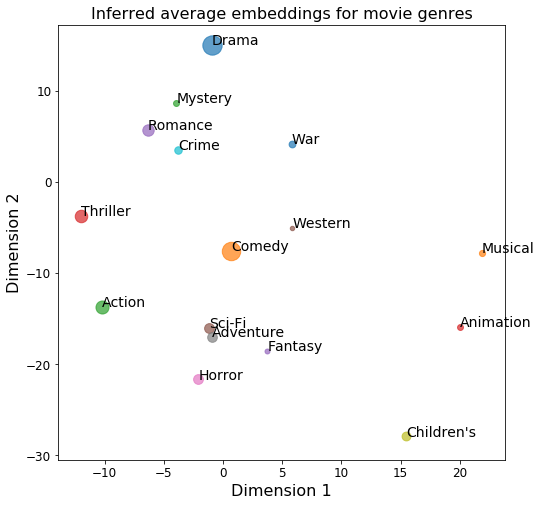

In [68]:
# Appendix Figure 2
Y_2d = TSNE(n_components=2).fit_transform(Y)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Inferred average embeddings for movie genres', fontsize=16)
for genre, count in Counter(all_genres).most_common():
    if count >= 50:
        in_genre = movie_df.genres.str.contains(genre)
        assert np.sum(in_genre) == count
        print('%s: n=%d' % (genre, count))
        x, y = np.mean(Y_2d[in_genre], axis=0)  # mean over movies in genre
        ax.scatter([x], [y], s=count*0.4, alpha=0.7)
        ax.annotate(genre, (x, y), fontsize=14)
ax.set_xlabel('Dimension 1', fontsize=16)
ax.set_ylabel('Dimension 2', fontsize=16)
ax.tick_params(labelsize=12)
plt.show()

## 2. Run simulations with fitted distributions

In [8]:
fn = 'test_movielens_users.pkl'  # generated from fitted user embeddings
f = open(fn, 'rb')
X = pickle.load(f)
f.close()
print(X.shape)

(300, 5)


In [9]:
noise_cov = np.cov(Y, rowvar=0) * 0.5
alphas = np.arange(0, 0.99, 0.05)
org_alpha2results = {}
for a in alphas:
    if a == 0:
        a = None
    else:
        a = round(a, 2)
    print('alpha =', a)
    choices = simulate_organic_model_with_alpha(X, Y, noise_cov, shrinkage_alpha=a, verbosity=20, n_trials=500)
    org_alpha2results[a] = choices

alpha = None
trial 0
trial 20
trial 40
trial 60
trial 80
trial 100
trial 120
trial 140
trial 160
trial 180
trial 200
trial 220
trial 240
trial 260
trial 280
trial 300
trial 320
trial 340
trial 360
trial 380
trial 400
trial 420
trial 440
trial 460
trial 480
alpha = 0.05
Running simulation with shrinkage alpha = 0.05
trial 0
trial 20
trial 40
trial 60
trial 80
trial 100
trial 120
trial 140
trial 160
trial 180
trial 200
trial 220
trial 240
trial 260
trial 280
trial 300
trial 320
trial 340
trial 360
trial 380
trial 400
trial 420
trial 440
trial 460
trial 480
alpha = 0.1
Running simulation with shrinkage alpha = 0.1
trial 0
trial 20
trial 40
trial 60
trial 80
trial 100
trial 120
trial 140
trial 160
trial 180
trial 200
trial 220
trial 240
trial 260
trial 280
trial 300
trial 320
trial 340
trial 360
trial 380
trial 400
trial 420
trial 440
trial 460
trial 480
alpha = 0.15
Running simulation with shrinkage alpha = 0.15
trial 0
trial 20
trial 40
trial 60
trial 80
trial 100
trial 120
trial 140
tri

In [10]:
noise_cov = np.cov(X, rowvar=0) * 0.5
alphas = np.arange(0, 0.99, 0.05)
rec_alpha2results = {}
for a in alphas:
    if a == 0:
        a = None
    else:
        a = round(a, 2)
    print('alpha =', a)
    choices = simulate_recommender_model_with_alpha(X, Y, noise_cov, shrinkage_alpha=a, verbosity=100, n_trials=500)
    rec_alpha2results[a] = choices

alpha = None
trial 0
trial 100
trial 200
trial 300
trial 400
alpha = 0.05
Running simulation with shrinkage alpha = 0.05
trial 0
trial 100
trial 200
trial 300
trial 400
alpha = 0.1
Running simulation with shrinkage alpha = 0.1
trial 0
trial 100
trial 200
trial 300
trial 400
alpha = 0.15
Running simulation with shrinkage alpha = 0.15
trial 0
trial 100
trial 200
trial 300
trial 400
alpha = 0.2
Running simulation with shrinkage alpha = 0.2
trial 0
trial 100
trial 200
trial 300
trial 400
alpha = 0.25
Running simulation with shrinkage alpha = 0.25
trial 0
trial 100
trial 200
trial 300
trial 400
alpha = 0.3
Running simulation with shrinkage alpha = 0.3
trial 0
trial 100
trial 200
trial 300
trial 400
alpha = 0.35
Running simulation with shrinkage alpha = 0.35
trial 0
trial 100
trial 200
trial 300
trial 400
alpha = 0.4
Running simulation with shrinkage alpha = 0.4
trial 0
trial 100
trial 200
trial 300
trial 400
alpha = 0.45
Running simulation with shrinkage alpha = 0.45
trial 0
trial 100
trial

In [53]:
true_sq_errs = cdist(X, Y) ** 2 
avg_dist_of_nn = []
for u in range(len(X)):
    dist_vec = sorted(true_sq_errs[u])
    avg_dist_of_nn.append(np.mean(dist_vec[:10]))
avg_dist_of_nn = np.array(avg_dist_of_nn)

plotting 285/300 users


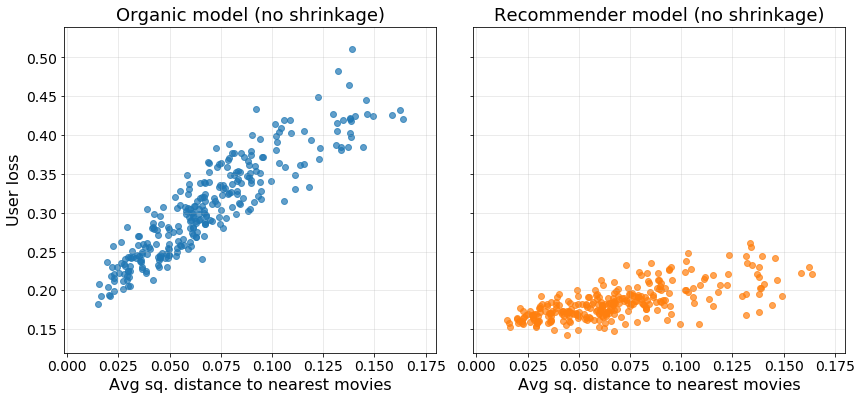

In [68]:
# Figure 6
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)
fig.subplots_adjust(wspace=0.1)
cutoff = np.percentile(avg_dist_of_nn, 95)
users_to_plot = avg_dist_of_nn < cutoff
print('plotting %d/%d users' % (np.sum(users_to_plot), len(X)))

ax = axes[0]
all_sq_errs = []
org_mle_choices = org_alpha2results[None]
for t in range(org_mle_choices.shape[1]):
    user_choices = org_mle_choices[:, t].astype(int)
    sq_errs = true_sq_errs[np.arange(len(X)), user_choices]
    all_sq_errs.append(sq_errs)
all_sq_errs = np.array(all_sq_errs)
mses = np.mean(all_sq_errs, axis=0)
assert len(mses) == len(X)
ax.set_title('Organic model (no shrinkage)', fontsize=18)
ax.scatter(avg_dist_of_nn[users_to_plot], mses[users_to_plot], color='tab:blue', alpha=0.7)
ax.set_xlabel('Avg sq. distance to nearest movies', fontsize=16)
ax.set_ylabel('User loss', fontsize=16)
ax.tick_params(labelsize=14)
ax.grid(alpha=0.3)

ax = axes[1]
all_sq_errs = []
rec_mle_choices = rec_alpha2results[None]
for t in range(rec_mle_choices.shape[1]):
    user_choices = rec_mle_choices[:, t].astype(int)
    sq_errs = true_sq_errs[np.arange(len(X)), user_choices]
    all_sq_errs.append(sq_errs)
all_sq_errs = np.array(all_sq_errs)
mses = np.mean(all_sq_errs, axis=0)
assert len(mses) == len(X)
ax.set_title('Recommender model (no shrinkage)', fontsize=18)
ax.scatter(avg_dist_of_nn[users_to_plot], mses[users_to_plot], color='tab:orange', alpha=0.7)
ax.set_xlabel('Avg sq. distance to nearest movies', fontsize=16)
ax.tick_params(labelsize=14)
ax.grid(alpha=0.3)

In [11]:
org_mse_vec = []
org_var_vec = []
rec_mse_vec = []
rec_var_vec = []

for a in alphas:
    if a == 0:
        a = None
    else:
        a = round(a, 2)
    mses_per_trial = []
    var_per_trial = []
    choices = org_alpha2results[a]
    for t in range(choices.shape[1]):
        user_choices = choices[:, t].astype(int)
        sq_errs = true_sq_errs[np.arange(len(X)), user_choices]
        mses_per_trial.append(np.mean(sq_errs))
        Yk = Y[user_choices]
        Yk_cov = np.cov(Yk, rowvar=0)
        var_per_trial.append(get_multivariate_variance(Yk_cov))
    org_mse_vec.append(np.mean(mses_per_trial))
    org_var_vec.append(np.mean(var_per_trial))
    
    mses_per_trial = []
    var_per_trial = []
    choices = rec_alpha2results[a]
    for t in range(choices.shape[1]):
        user_choices = choices[:, t].astype(int)
        sq_errs = true_sq_errs[np.arange(len(X)), user_choices]
        mses_per_trial.append(np.mean(sq_errs))
        Yk = Y[user_choices]
        Yk_cov = np.cov(Yk, rowvar=0)
        var_per_trial.append(get_multivariate_variance(Yk_cov))
    rec_mse_vec.append(np.mean(mses_per_trial))
    rec_var_vec.append(np.mean(var_per_trial))

/dfs/scratch0/serinac/polar_rec/helper_functions_for_empirics.py:76: RuntimeWarning: invalid value encountered in log
  log_prod = np.sum(np.log(eigenvals))
/dfs/scratch0/serinac/polar_rec/helper_functions_for_empirics.py:76: RuntimeWarning: divide by zero encountered in log
  log_prod = np.sum(np.log(eigenvals))


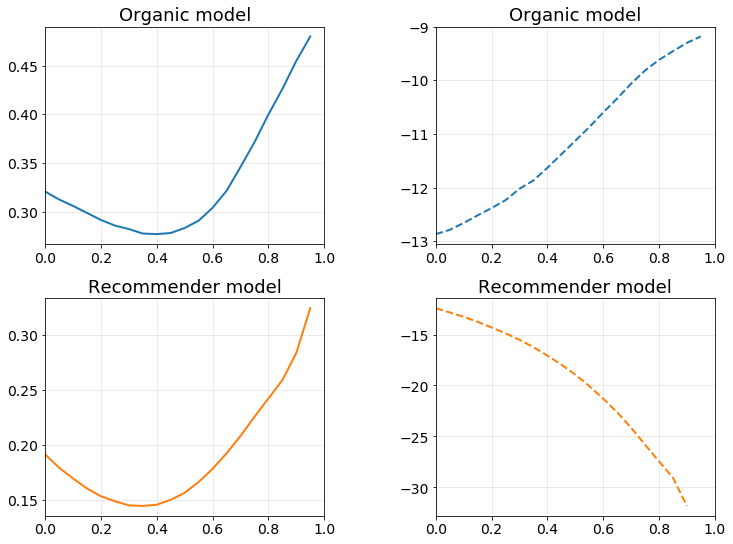

In [67]:
# Figure 7
fig, axes = plt.subplots(2, 2, figsize=(12,9))
fig.subplots_adjust(hspace=0.25)
fig.subplots_adjust(wspace=0.4)
ax = axes[0][0]
ax.set_title('Organic model', fontsize=18)
ax.plot(alphas, org_mse_vec, color='tab:blue', linewidth=2)
ax.tick_params(labelsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(0, 1)

ax = axes[0][1]
ax.set_title('Organic model', fontsize=18)
ax.plot(alphas, org_var_vec, color='tab:blue', linestyle='dashed', linewidth=2)
ax.tick_params(labelsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(0, 1)

ax = axes[1][0]
ax.set_title('Recommender model', fontsize=18)
ax.plot(alphas, rec_mse_vec, color='tab:orange', linewidth=2)
ax.tick_params(labelsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(0, 1)

ax = axes[1][1]
ax.set_title('Recommender model', fontsize=18)
ax.plot(alphas, rec_var_vec, color='tab:orange', linestyle='dashed', linewidth=2)
ax.tick_params(labelsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(0, 1)

plt.show()